# End-Point ML Training (Point Cloud → Beam Parameters)

This notebook trains a **PointNet-style regression model** on **3D point clouds** stored in JSON files.  
Each JSON represents one beam/sample and contains metadata + a point cloud. The training pipeline loads all JSON files from a folder, builds PyTorch datasets/dataloaders, trains a neural network, and saves the best model checkpoint + training history + figures.

---

## What this notebook does (high level)
1. **Setup & reproducibility**
   - Imports libraries, sets random seeds, and checks whether **CUDA (GPU)** is available.
2. **Load data from JSON**
   - Reads **all `*.json` files** in a chosen input directory.
   - Validates that required fields exist and that point clouds have the expected shape.
3. **Prepare train/validation split**
   - Splits samples into train/val **without re-reading JSON**.
4. **Train a PointNet regression model (PyTorch)**
   - Feeds point clouds `(N, 3)` into a PointNet-like network.
   - Optimizes a regression loss and tracks validation loss.
   - Saves the **best** model checkpoint.
5. **Save outputs**
   - Writes plots/figures, model checkpoint, and a `.history.json` training log.

---

## Key libraries used
- **PyTorch** (`torch`, `torch.nn`, `DataLoader`) for model + training loop
- **NumPy** for data handling
- **Matplotlib** for plots
- Python stdlib: `json`, `pathlib`, `random`, `time`, `math`, etc.

---

## Where to change the input data location
Look for the cell that defines:

```python
USER_SET_INPUT_DIR = r"...your folder..."
INPUT_DIR = Path(USER_SET_INPUT_DIR)


## Setup & Installs

Run the next cell to install the minimum packages.

In [1]:

# If you run this on a new environment, uncomment the next lines.
# In some environments, you might prefer installing with conda.
# This uses CPU-only PyTorch wheels by default.

# !pip install --upgrade pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install numpy matplotlib
# (Optional) for nicer 3D plots: # !pip install plotly

import math, random, os, time
import numpy as np
import matplotlib.pyplot as plt
import json

# Try to import torch and handle the case where it isn't available yet.
try:
    import torch
    from torch import nn
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception as e:
    TORCH_AVAILABLE = False
    print("PyTorch not found. Please install it, then re-run. Error:", e)
    print("You can uncomment the installation lines at the top of the script.")


## Reproducibility setup

Machine learning models use random processes — such as data shuffling, weight initialization, and batch sampling — which can cause small variations between runs.  
To ensure results are **reproducible**, we set fixed random seeds for Python, NumPy, and PyTorch.  


In [2]:

# --- Reproducibility setup ---
import os, random, numpy as np, torch

SEED = 42  # any integer value works fine

# Python and NumPy
random.seed(SEED)
np.random.seed(SEED)

# PyTorch (CPU and GPU)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make CUDA deterministic (slightly slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Reproducibility enabled (SEED={SEED})")


✅ Reproducibility enabled (SEED=42)


## Check if CUDA is available to use GPU acceleration.

In [30]:
import torch

if torch.cuda.is_available():
    print("CUDA available ✅")
    print(torch.version.cuda)            # CUDA toolkit version your torch was built with
    print(torch.cuda.get_device_name(0)) # GPU name
else:
    print("CUDA not available ❌ (CPU-only build or no NVIDIA GPU/drivers)")

# Manual override: choose "cuda" or "cpu"
USE_GPU = True  # 👈 set to False if you want to force CPU

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Optionally print CUDA info
if device.type == "cuda":
    print("CUDA version:", torch.version.cuda)
    print("Torch CUDA available:", torch.cuda.is_available())


CUDA available ✅
13.0
NVIDIA RTX 2000 Ada Generation Laptop GPU
Using GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU
CUDA version: 13.0
Torch CUDA available: True


## Set number of points

Set N_PONTS to the same amount as the number of points the trainingset is made with. 

In [33]:
N_POINTS = 3072

## Load Data from JSON

Set Input folder below:
    USER_SET_INPUT_DIR = r"C:\YourDatasetFolder"
    This will load all .JSON files in the folder. 

In [29]:
from pathlib import Path
import json
import numpy as np
import re


def load_multiple_jsons(input_dir: Path):
    """
    Read ALL JSON files in the directory and merge them.
    Expects new structure: id, c, v, t1, t2, cloud
    """
    json_paths = sorted(input_dir.glob("*.json"))

    if not json_paths:
        raise FileNotFoundError(f"No JSON-file in {input_dir}")

    all_ids   = []
    all_clouds = []
    all_cs    = []
    all_vs    = []
    all_t1s   = []
    all_t2s   = []
    all_counts = []

    for jp in json_paths:
        print(f"Read: {jp.name}")
        ids, clouds, cs, vs, t1s, t2s, counts = load_beams_from_json(jp)

        all_ids.extend(ids)
        all_clouds.extend(clouds)
        all_cs.extend(cs)
        all_vs.extend(vs)
        all_t1s.extend(t1s)
        all_t2s.extend(t2s)
        all_counts.extend(counts)

    print(f"\nTotal numbers of beams from {len(json_paths)} filer: {len(all_ids)}")
    return all_ids, all_clouds, all_cs, all_vs, all_t1s, all_t2s, all_counts


def to_point(arr):
    """Sikker konvertering av [x,y,z] -> np.ndarray(shape=(3,), float32)."""
    if not isinstance(arr, (list, tuple)) or len(arr) != 3:
        return None
    try:
        return np.asarray(arr, dtype=np.float32)
    except Exception:
        return None


def load_beams_from_json(json_path: Path):
    with json_path.open("r", encoding="utf-8") as f:
        text = f.read()
    # fjern BOM hvis den er der
    if text.startswith("\ufeff"):
        text = text.lstrip("\ufeff")
    data = json.loads(text)
    beams = data.get("beams", [])
    if not isinstance(beams, list):
        raise ValueError("Unespected JSON-format: 'beams' is not a list.")

    ids, clouds, cs, vs, t1s, t2s, counts = [], [], [], [], [], [], []

    for b in beams:
        bid = str(b.get("id", ""))

        cloud_list = b.get("cloud", []) or []
        c = to_point(b.get("c"))
        v = to_point(b.get("v"))

        # ---- SJEKK: c og v må finnes ----
        if c is None:
            raise ValueError(f"Missing valid 'c' for beam {bid}")
        if v is None:
            raise ValueError(f"Missing valid 'v' for beam {bid}")

        # t1 og t2 som float
        t1_raw = b.get("t1", None)
        t2_raw = b.get("t2", None)

        try:
            t1 = float(t1_raw)
        except (TypeError, ValueError):
            raise ValueError(f"Missing valid 't1' for beam {bid}: {t1_raw}")

        try:
            t2 = float(t2_raw)
        except (TypeError, ValueError):
            raise ValueError(f"Missing valid 't2' for beam {bid}: {t2_raw}")

        # sky til (N,3) float32
        pts = []
        for p in cloud_list:
            pp = to_point(p)
            if pp is not None:
                pts.append(pp)

        pts = np.vstack(pts).astype(np.float32) if pts else np.zeros((0, 3), dtype=np.float32)

        # ---- SJEKK: punktsky må ha punkter ----
        if pts.shape[0] == 0:
            raise ValueError(f"No points in beam {bid}")

        # point_count: bruk JSON-feltet hvis finnes, ellers len(pts)
        pc_json = b.get("point_count", None)
        pc = int(pc_json) if isinstance(pc_json, (int, float)) else int(pts.shape[0])

        # ---- SJEKK: point_count må stemme ----
        if pc != pts.shape[0]:
            raise ValueError(
                f"point_count ({pc}) do not equal ({pts.shape[0]}) for beams {bid}"
            )

        ids.append(bid)
        clouds.append(pts)
        cs.append(c)
        vs.append(v)
        t1s.append(np.float32(t1))
        t2s.append(np.float32(t2))
        counts.append(pc)

    print(f"[OK] Validated {len(ids)} beams – all c/v/t1/t2 og pointclouds are OK.")
    return ids, clouds, cs, vs, t1s, t2s, counts


# ----------------- Kjør lasting -----------------
# --- INPUT_DIR (synlig og lett å endre) ---
USER_SET_INPUT_DIR = r"C:\Dataset(Rotations and new input)\test"  # <-- din INPUT-mappe //
if USER_SET_INPUT_DIR:
    INPUT_DIR = Path(USER_SET_INPUT_DIR)
else:
    print("No Input directory set. Please set USER_SET_INPUT_DIR to your input folder path.")

ids, clouds, cs, vs, t1s, t2s, counts = load_multiple_jsons(INPUT_DIR)
NUM_BEAMS = len(ids)

print(f"Nr. of input files: {len(list(INPUT_DIR.glob('*.json')))}")
print(f"Tot. Nr. of beams: {NUM_BEAMS}")


# --------- Visuell kontroll (print np.ndarray) ----------
np.set_printoptions(precision=3, suppress=True, linewidth=120)

# --- Justerbare parametre ---
NUM_BEAMS_TO_PRINT = 4    # hvor mange bjelker du vil vise
NUM_POINTS_TO_PRINT = 2   # hvor mange punkter per punktsky du vil vise

# Begrens antall bjelker
num_beams = min(NUM_BEAMS_TO_PRINT, len(ids))

print(f"Show the first {num_beams} beams, with {NUM_POINTS_TO_PRINT} points in each cloud.\n")

for i in range(num_beams):
    bid = ids[i]
    print(f"#{i+1}  id={bid}")
    print(f"  cloud shape: {clouds[i].shape}, dtype: {clouds[i].dtype}")

    n_pts = min(NUM_POINTS_TO_PRINT, len(clouds[i]))
    if n_pts > 0:
        print(f"  cloud sample (første {n_pts} av {len(clouds[i])}):\n{clouds[i][:n_pts]}")
    else:
        print("  cloud sample: (tom)")

    print(f"  c      : {cs[i]}  (shape={cs[i].shape}, dtype={cs[i].dtype})")
    print(f"  v      : {vs[i]}  (shape={vs[i].shape}, dtype={vs[i].dtype})")
    print(f"  t1     : {t1s[i]}  (dtype={type(t1s[i])})")
    print(f"  t2     : {t2s[i]}  (dtype={type(t2s[i])})")
    print(f"  point_count (json/len): {counts[i]}/{clouds[i].shape[0]}")
    print("-"*80)


Read: Type_1_1000_P.1024.json
[OK] Validated 1000 beams – all c/v/t1/t2 og pointclouds are OK.

Total numbers of beams from 1 filer: 1000
Nr. of input files: 1
Tot. Nr. of beams: 1000
Show the first 4 beams, with 2 points in each cloud.

#1  id=Type_1_0001
  cloud shape: (1024, 3), dtype: float32
  cloud sample (første 2 av 1024):
[[  53.41   182.614  363.733]
 [ -67.5   -123.697 -174.266]]
  c      : [  0.    -35.826 -39.825]  (shape=(3,), dtype=float32)
  v      : [0.    0.669 0.743]  (shape=(3,), dtype=float32)
  t1     : -440.4318542480469  (dtype=<class 'numpy.float32'>)
  t2     : -547.5681762695312  (dtype=<class 'numpy.float32'>)
  point_count (json/len): 1024/1024
--------------------------------------------------------------------------------
#2  id=Type_1_0002
  cloud shape: (1024, 3), dtype: float32
  cloud sample (første 2 av 1024):
[[ -57.5     72.243  -93.464]
 [  16.401  756.103 -324.602]]
  c      : [  0.     32.803 -10.44 ]  (shape=(3,), dtype=float32)
  v      : [ 0.

## Controll code for unit vector. All directionvectors should be unitized in the Grasshopper script. 

In [ ]:
#Validate unit vector: 
for i in range(NUM_BEAMS): 
    v = vs[i]
    length = np.linalg.norm(v)
    print(f"Beam ID: {ids[i]} - Vector Length: {length:.6f} {'(Valid Unit Vector)' if np.isclose(length, 1.0) else '(Invalid Unit Vector)'}")

Beam ID: Type_1_0001 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0002 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0003 - Vector Length: 0.999999 (Valid Unit Vector)
Beam ID: Type_1_0004 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0005 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0006 - Vector Length: 0.999999 (Valid Unit Vector)
Beam ID: Type_1_0007 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0008 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0009 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0010 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0011 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0012 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0013 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0014 - Vector Length: 1.000000 (Valid Unit Vector)
Beam ID: Type_1_0015 - Vector Length: 1.000000 (Valid Unit Vec

## Output folder and result files

All result files are saved **next to the input data folder**.

A new folder is automatically created:

`<INPUT_DIR>/ResultFiles<NUM_BEAMS>/`

This folder contains:
- Model checkpoint (`.pt`)
- Training history (`.json`)
- Saved figures (`.png`, `.pdf`)

The number in the folder name reflects how many beams (`NUM_BEAMS`) were loaded from the input data.


In [ ]:


from pathlib import Path
import re
import matplotlib.pyplot as plt

def get_figure_dir_for_input(input_path: Path, suffix="figures", make=True) -> Path:
    """
    Lager/returnerer en mappe ved siden av inputfila:
      <input.stem><suffix>   (f.eks. mydatafigures)
    """
    input_path = Path(input_path)
    figdir = input_path.parent / f"{input_path.stem}{suffix}"
    if make:
        figdir.mkdir(parents=True, exist_ok=True)
    return figdir

def _sanitize_filename(name: str) -> str:
    # erstatt “rare” tegn med "_"
    return re.sub(r"[^A-Za-z0-9._-]+", "_", name).strip("_")

def save_fig(fig, out_dir: Path, name: str, dpi=150, formats=("png","pdf")):
    """
    Lagrer en enkelt figur til out_dir i de oppgitte formatene.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    safe = _sanitize_filename(name)
    saved = []
    for ext in formats:
        p = out_dir / f"{safe}.{ext}"
        fig.savefig(p, dpi=dpi if ext.lower()=="png" else None, bbox_inches="tight")
        saved.append(p)
    return saved



from pathlib import Path

FIG_DIR = INPUT_DIR / f"ResultFiles{NUM_BEAMS}"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(name: str, fig=None, dpi=None, _formats=None):
    """
    Enkel wrapper rundt save_fig som lagrer i FIG_DIR.
    Filene havner i:
      <INPUT_DIR>/ResultFiles<NUM_BEAMS>/<name>.(png/pdf)
    """
    if fig is None:
        fig = plt.gcf()
    return save_fig(
        fig=fig,
        out_dir=FIG_DIR,
        name=name,
        dpi=dpi if dpi is not None else 150,
        formats=_formats if _formats is not None else ("png", "pdf"),
    )
from pathlib import Path

CKPT_PATH = FIG_DIR / "pointnet_reg_best.pt"
print(f"Checkpoint lagres til: {CKPT_PATH}")

print(f"Lagrer figurer til: {FIG_DIR}")



Checkpoint lagres til: C:\Dataset(Rotations and new input)\test\ResultFiles1000\pointnet_reg_best.pt
Lagrer figurer til: C:\Dataset(Rotations and new input)\test\ResultFiles1000


## Train / validation split

This section splits the dataset into a **training set** and a **validation set**.

You can control the split ratio using:

`VAL_RATIO = 0.2`

This means:
- 80% of the beams are used for training
- 20% are used for validation

In [34]:
# --- Train/Val split uten å lese JSON på nytt ---
import numpy as np
import random

def split_train_val(ids, clouds, cs, vs, t1s, t2s, counts, val_ratio=0.2, seed=42, shuffle=True):
    """
    Deler allerede lastede lister i train/val på en deterministisk måte.
    Alt holdes i samme rekkefølge via indekser.
    """
    n = len(ids)
    assert n == len(clouds) == len(cs) == len(vs) == len(t1s) == len(t2s) == len(counts), \
        "Ulike lengder i datastrukturene."
    if n < 2:
        raise ValueError("Trenger minst 2 bjelker for å gjøre en split.")

    # deterministisk RNG
    rng = np.random.RandomState(seed)

    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)

    n_val = max(1, int(round(val_ratio * n)))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    def take(arr, ind):
        return [arr[i] for i in ind]

    train = {
        "ids":     take(ids, train_idx),
        "clouds":  take(clouds, train_idx),
        "cs":      take(cs, train_idx),
        "vs":      take(vs, train_idx),
        "t1s":     take(t1s, train_idx),
        "t2s":     take(t2s, train_idx),
        "counts":  take(counts, train_idx),
        "index":   train_idx.tolist(),
    }
    val = {
        "ids":     take(ids, val_idx),
        "clouds":  take(clouds, val_idx),
        "cs":      take(cs, val_idx),
        "vs":      take(vs, val_idx),
        "t1s":     take(t1s, val_idx),
        "t2s":     take(t2s, val_idx),
        "counts":  take(counts, val_idx),
        "index":   val_idx.tolist(),
    }
    return train, val

# ---- kjør splitt ----
VAL_RATIO = 0.2            # f.eks. 20% til validering
SEED_FOR_SPLIT = SEED      # bruk samme SEED som tidligere for reproducerbarhet
SHUFFLE_SPLIT = True       # bland før splitt

train, val = split_train_val(
    ids, clouds, cs, vs, t1s, t2s, counts,
    val_ratio=VAL_RATIO, seed=SEED_FOR_SPLIT, shuffle=SHUFFLE_SPLIT
)

print(f"Total beams: {len(ids)}")
print(f"Train: {len(train['ids'])}  |  Val: {len(val['ids'])}")
print(f"Train indices: {train['index']}")
print(f"Val indices  : {val['index']}")

# (valgfritt) liten sanity-print av første element i hver del
def brief_info(part, name):
    if not part["ids"]:
        print(f"{name}: (empty)")
        return
    
    i = random.randrange(len(part["ids"]))   # 🎯 tilfeldig index
    bid = part["ids"][i]

    print(f"\n{name} sample -> id={bid}")
    print(f"  cloud shape: {part['clouds'][i].shape}")
    print(f"  c   : {part['cs'][i]}")
    print(f"  v   : {part['vs'][i]}")
    print(f"  t1  : {part['t1s'][i]}")
    print(f"  t2  : {part['t2s'][i]}")

brief_info(train, "Train")
brief_info(val, "Val")


Total beams: 1000
Train: 800  |  Val: 200
Train indices: [29, 535, 695, 557, 836, 596, 165, 918, 495, 824, 65, 141, 925, 827, 655, 331, 664, 249, 907, 708, 305, 734, 975, 49, 896, 2, 544, 350, 904, 536, 344, 994, 481, 575, 33, 31, 231, 963, 192, 333, 3, 204, 514, 799, 306, 109, 430, 77, 84, 286, 82, 991, 789, 894, 398, 323, 519, 916, 922, 5, 731, 465, 97, 266, 357, 868, 798, 380, 631, 381, 490, 118, 900, 250, 523, 9, 196, 603, 81, 783, 587, 797, 239, 290, 211, 717, 359, 449, 227, 950, 946, 796, 501, 464, 362, 468, 935, 428, 7, 155, 541, 440, 482, 422, 778, 949, 334, 576, 934, 567, 594, 530, 581, 707, 448, 453, 228, 352, 728, 212, 79, 148, 302, 628, 777, 506, 342, 485, 711, 133, 703, 311, 722, 629, 0, 316, 706, 547, 872, 532, 477, 404, 172, 125, 394, 420, 552, 903, 90, 939, 181, 274, 895, 69, 291, 131, 300, 424, 326, 144, 423, 580, 135, 450, 164, 28, 773, 193, 388, 852, 169, 705, 140, 173, 6, 745, 478, 73, 910, 813, 238, 145, 792, 234, 220, 923, 500, 132, 990, 774, 185, 41, 696, 108, 58

## Dataset & DataLoader (training inputs)

This cell builds the PyTorch `Dataset` and `DataLoader` used during training.

Each sample returns:
- `points`: point cloud tensor with shape **(N, 3)**
- `v_gt`: ground-truth axis direction with shape **(3,)**
- `c_gt`: ground-truth point on the axis with shape **(3,)**
- `id`: beam identifier (for debugging / tracking)

The dataloaders **do not re-read any JSON files** — they wrap the already loaded `train` and `val` dictionaries.

**Note:** If you later want to also train on `t1/t2`, you must (1) include them in the dataset output and (2) update the model output size and loss accordingly.


In [37]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class BeamParamDataset(Dataset):
    def __init__(self, data_dict):
        self.ids    = data_dict["ids"]
        self.clouds = data_dict["clouds"]
        self.cs     = data_dict["cs"]
        self.vs     = data_dict["vs"]

        n = len(self.ids)
        assert n == len(self.clouds) == len(self.cs) == len(self.vs), "Length mismatch in dataset fields."

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        points = torch.from_numpy(self.clouds[i].astype(np.float32, copy=False))  # (N,3)

        c_gt = torch.from_numpy(np.asarray(self.cs[i], dtype=np.float32))  # (3,)
        v_gt = torch.from_numpy(np.asarray(self.vs[i], dtype=np.float32))  # (3,)

        return {"id": self.ids[i], "points": points, "c_gt": c_gt, "v_gt": v_gt}


def make_dataloaders(train_dict, val_dict, batch_size=16, num_workers=0, shuffle_train=True):
    train_loader = DataLoader(
        BeamParamDataset(train_dict),
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    val_loader = DataLoader(
        BeamParamDataset(val_dict),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    return train_loader, val_loader


BATCH_SIZE  = 128
NUM_WORKERS = 0

train_loader, val_loader = make_dataloaders(train, val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("points shape:", batch["points"].shape)  # (B, N, 3)
print("c_gt shape:", batch["c_gt"].shape)      # (B, 3)
print("v_gt shape:", batch["v_gt"].shape)      # (B, 3)
print("ids:", batch["id"][:3])


Batch keys: dict_keys(['id', 'points', 'c_gt', 'v_gt'])
points shape: torch.Size([128, 1024, 3])
c_gt shape: torch.Size([128, 3])
v_gt shape: torch.Size([128, 3])
ids: ['Type_1_0914', 'Type_1_0687', 'Type_1_0365']


## PointNet model and loss function

This cell defines the PointNet-based regression model and the loss function used during training.

**Model input**
- `points`: point cloud tensor with shape **(B, N, 3)**

**Model output**
- `v_pred`: predicted axis direction **(B, 3)** (unit vector)
- `c_pred`: predicted axis position **(B, 3)** (canonical point on axis)

**Loss function**
Training uses the combined `axis_position_loss`, which includes:
- Direction loss (`Lv`): compares predicted and ground-truth axis direction
- Position loss (`Lc`): compares predicted and ground-truth axis position

The total loss is computed as:

`loss = wv * Lv + wc * Lc`

You can adjust the relative importance of direction vs position by changing the weights:
- `wv` → weight for direction loss
- `wc` → weight for position loss

Example:
```python
loss, Lv, Lc = axis_position_loss(v_pred, c_pred, v_gt, c_gt, wv=1.0, wc=0.5)


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetReg(nn.Module):
    """
    PointNet-style regressor for axis direction + axis position.

    Input:
      - points: (B, N, 3)

    Output:
      - v_pred: (B, 3) unit direction vector
      - c_pred: (B, 3) canonical axis point (enforced to be perpendicular to v_pred)
    """
    def __init__(self, feat_dims=(64, 128, 256), head_dims=(256, 128), dropout_p=0.3):
        super().__init__()
        c1, c2, c3 = feat_dims
        h1, h2 = head_dims

        # Shared point MLP (Conv1d over points)
        self.conv1 = nn.Conv1d(3,  c1, 1, bias=False)
        self.bn1   = nn.BatchNorm1d(c1)
        self.conv2 = nn.Conv1d(c1, c2, 1, bias=False)
        self.bn2   = nn.BatchNorm1d(c2)
        self.conv3 = nn.Conv1d(c2, c3, 1, bias=False)
        self.bn3   = nn.BatchNorm1d(c3)

        # FC head
        self.fc1   = nn.Linear(c3, h1, bias=False)
        self.bn4   = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(dropout_p)

        self.fc2   = nn.Linear(h1, h2, bias=False)
        self.bn5   = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(dropout_p)

        # Predict raw (v, c): 6 values
        self.fc_out = nn.Linear(h2, 6)

        # Weight init
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        if x.dim() != 3 or x.size(-1) != 3:
            raise ValueError(f"Expected (B, N, 3), got {tuple(x.shape)}")

        # (B, N, 3) -> (B, 3, N)
        x = x.transpose(1, 2)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Global max pooling: (B, c3)
        x = x.max(dim=2)[0]

        x = self.drop1(F.relu(self.bn4(self.fc1(x))))
        x = self.drop2(F.relu(self.bn5(self.fc2(x))))

        raw = self.fc_out(x)          # (B, 6)
        v_raw = raw[:, 0:3]           # (B, 3)
        c_raw = raw[:, 3:6]           # (B, 3)

        # Normalize direction and canonicalize c to be perpendicular to v
        v = F.normalize(v_raw, dim=1, eps=1e-8)
        c = c_raw - (c_raw * v).sum(dim=1, keepdim=True) * v

        return v, c


def axis_position_loss(v_pred, c_pred, v_gt, c_gt, wv=1.0, wc=1.0, eps=1e-8):
    """
    Combined loss for axis direction + axis position.

    - Direction loss: sign-invariant cosine loss (v and -v are treated as equal)
    - Position loss : SmoothL1 on canonical axis point (also canonicalized)
    """
    v_pred = F.normalize(v_pred, dim=1, eps=eps)
    v_gt   = F.normalize(v_gt,   dim=1, eps=eps)

    cos = (v_pred * v_gt).sum(dim=1)
    Lv = (1.0 - torch.abs(cos)).mean()

    c_pred = c_pred - (c_pred * v_pred).sum(dim=1, keepdim=True) * v_pred
    c_gt   = c_gt   - (c_gt   * v_gt  ).sum(dim=1, keepdim=True) * v_gt
    Lc = F.smooth_l1_loss(c_pred, c_gt)

    return wv * Lv + wc * Lc, Lv.detach(), Lc.detach()


# --- Mini-test ---
model = PointNetReg().to(device)
model.train()

batch = next(iter(train_loader))
x    = batch["points"].to(device)
v_gt = batch["v_gt"].to(device)
c_gt = batch["c_gt"].to(device)

with torch.no_grad():
    v_pred, c_pred = model(x)

loss, Lv, Lc = axis_position_loss(v_pred, c_pred, v_gt, c_gt)

print(f"points: {tuple(x.shape)}  v_pred: {tuple(v_pred.shape)}  c_pred: {tuple(c_pred.shape)}")
print(f"loss: {loss.item():.6f}  Lv: {Lv.item():.6f}  Lc: {Lc.item():.6f}")


points: (128, 1024, 3)  v_pred: (128, 3)  c_pred: (128, 3)
loss: 0.759568  Lv: 0.470998  Lc: 0.288570


## Training loop (PointNet)

This cell runs the full training and validation loop for the PointNet model.

**What happens here**
- Defines a training configuration (`CFG`) with hyperparameters such as learning rate, epochs, weight decay, gradient clipping, and scheduler settings.
- Runs one epoch at a time using `_run_epoch(...)`:
  - **Train mode** when an optimizer is provided
  - **Validation mode** when `optimizer=None`
- Uses the combined `axis_position_loss` (direction + position) and logs both components:
  - `Lv` = direction loss (sign-invariant)
  - `Lc` = position loss (SmoothL1 on canonicalized `c`)
- Computes additional metrics for monitoring:
  - mean axis angle error (degrees), accuracy within 2°/5°
  - direction R² (sign-aligned)
  - position RMSE

**Outputs**
- Saves the best model checkpoint (lowest validation loss) to:
  - `CFG["ckpt_path"]` (typically inside `<INPUT_DIR>/ResultFiles<NUM_BEAMS>/`)
- Saves the full training history to a JSON file next to the checkpoint:
  - `<ckpt_path>.history.json`

**Early stopping**
- Training stops early if validation loss does not improve for `CFG["early_stopping_patience"]` epochs.


In [41]:
import math, time, torch
import torch.nn.functional as F
from pathlib import Path
import json

# ---------------------------------------------------------------------------
# 🔁 AMP (Automatic Mixed Precision) kompatibilitet
# ---------------------------------------------------------------------------
try:
    from torch.amp import GradScaler as _GradScaler, autocast as _autocast
    _AMP_NEW_API = True
except Exception:
    from torch.cuda.amp import GradScaler as _GradScaler, autocast as _autocast
    _AMP_NEW_API = False


def _scaler_unscale(scaler, optimizer):
    if hasattr(scaler, "unscale_"):
        scaler.unscale_(optimizer)
    elif hasattr(scaler, "unscale_grad_"):
        scaler.unscale_grad_(optimizer)


# ----------------------- ⚙️ Treningskonfig ----------------------------------
CFG = {
    "lr": 5e-4,
    "weight_decay": 1e-5,
    "epochs": 100,
    "grad_clip": 1.0,
    "use_amp": False,
    "print_every": 1,
    "ckpt_path": str(CKPT_PATH),
    "step_size": 15,
    "gamma": 0.5,
    "early_stopping_patience": 100,
}


def _run_epoch(model, loader, optimizer=None, scaler=None, device="cpu", grad_clip=1.0):
    """
    Kjør ÉN epoke (train eller val):

      - Hvis optimizer != None → TRAIN
      - Ellers → EVAL

    Returnerer bl.a.:
      - "loss":      total loss = wv*Lv + wc*Lc
      - "Lv":        retnings-loss (1 - |cos|)
      - "Lc":        posisjons-loss (SmoothL1 på canonisk c)
      - "r2_dir":    R² for retning (akse, v og -v samme)
      - "pos_rmse":  RMSE på posisjon (samme enhet som c)
      - "angle_deg": mean akse-vinkelfeil (0–90°)
    """
    is_train = optimizer is not None
    model.train(is_train)

    # Akkumulering av loss
    total_loss = 0.0
    total_Lv   = 0.0
    total_Lc   = 0.0
    total_n    = 0

    # Akkumulering for vinkel/accuracy (akse-vinkel)
    angle_sum_rad = 0.0
    acc5_count    = 0.0
    acc2_count    = 0.0

    # --- R² for retning (akse), sign-justert ---
    sum_y_dir       = 0.0
    sum_y2_dir      = 0.0
    sum_e2_dir      = 0.0
    total_numel_dir = 0

    # --- RMSE for posisjon i tverrsnitt (canonisk c) ---
    sum_e2_pos      = 0.0
    total_numel_pos = 0

    # For per-akse-statistikk (på v, uten sign-justering – mest for debugging)
    axis_se_sum   = torch.zeros(3, dtype=torch.float64, device=device)
    sum_y_axis    = torch.zeros(3, dtype=torch.float64, device=device)
    sum_y2_axis   = torch.zeros(3, dtype=torch.float64, device=device)
    axis_count    = 0

    use_bf16 = (device.type == "cuda") and torch.cuda.is_bf16_supported()
    eps = 1e-8

    for batch in loader:
        x    = batch["points"].to(device, non_blocking=True)  # (B, N, 3)
        v_gt = batch["v_gt"].to(device, non_blocking=True)    # (B, 3)
        c_gt = batch["c_gt"].to(device, non_blocking=True)    # (B, 3)
        B, D = v_gt.shape                                     # D = 3

        if is_train:
            optimizer.zero_grad(set_to_none=True)

            if scaler is not None:
                # --- TRAIN med AMP ---
                with _autocast(
                    device_type=device.type,
                    dtype=(torch.bfloat16 if use_bf16 else torch.float16),
                    enabled=True,
                ):
                    v_pred, c_pred = model(x)
                    loss, Lv, Lc = axis_position_loss(v_pred, c_pred, v_gt, c_gt)

                scaler.scale(loss).backward()

                if grad_clip is not None:
                    _scaler_unscale(scaler, optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                scaler.step(optimizer)
                scaler.update()

            else:
                # --- TRAIN uten AMP ---
                v_pred, c_pred = model(x)
                loss, Lv, Lc = axis_position_loss(v_pred, c_pred, v_gt, c_gt)

                loss.backward()

                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                optimizer.step()
        else:
            # --- VALIDASJON ---
            with torch.no_grad():
                v_pred, c_pred = model(x)
                loss, Lv, Lc = axis_position_loss(v_pred, c_pred, v_gt, c_gt)

        # Akkumuler loss
        total_loss += float(loss) * B
        total_Lv   += float(Lv)   * B
        total_Lc   += float(Lc)   * B
        total_n    += B

        # --- METRIKKER (uten gradient) ---
        with torch.no_grad():
            y_det    = v_gt.detach()      # (B,3)
            yhat_det = v_pred.detach()    # (B,3)

            # Normaliser retningene
            target_n = F.normalize(y_det,    dim=1, eps=eps)
            pred_n   = F.normalize(yhat_det, dim=1, eps=eps)

            # Dot-produkt
            dot = (pred_n * target_n).sum(dim=1)  # (B,)

            # Fortegns-INVARIANT akse-vinkel (for angle/acc)
            dot_axis = dot.abs().clamp(-1.0 + eps, 1.0 - eps)
            angle_rad = torch.acos(dot_axis)               # (B,)
            angle_deg = angle_rad * 180.0 / math.pi        # (B,)

            angle_sum_rad += angle_rad.sum().item()
            acc5_count    += (angle_deg < 5.0).sum().item()
            acc2_count    += (angle_deg < 2.0).sum().item()

            # --- R² for retning (akse): sign-align pred mot gt ---
            sign = torch.where(dot >= 0,
                               torch.ones_like(dot),
                               -torch.ones_like(dot))        # (B,)
            sign = sign.view(-1, 1)                          # (B,1)

            v_pred_aligned = pred_n * sign                   # (B,3)

            err_dir = (v_pred_aligned - target_n).to(torch.float64)

            sum_e2_dir      += (err_dir ** 2).sum().item()
            sum_y_dir       += target_n.sum().item()
            sum_y2_dir      += (target_n ** 2).sum().item()
            total_numel_dir += target_n.numel()

            # --- RMSE for posisjon i tverrsnitt ---
            c_pred_det = c_pred.detach()
            c_gt_det   = c_gt.detach()

            c_pred_can = c_pred_det - (c_pred_det * pred_n).sum(dim=1, keepdim=True) * pred_n
            c_gt_can   = c_gt_det   - (c_gt_det   * target_n).sum(dim=1, keepdim=True) * target_n

            err_pos = (c_pred_can - c_gt_can).to(torch.float64)
            sum_e2_pos      += (err_pos ** 2).sum().item()
            total_numel_pos += B

            # --- Per-akse-statistikk for v (uten sign-align, mest debugging) ---
            err_full = (yhat_det - y_det).to(torch.float64)  # (B,3)
            axis_se_sum += (err_full ** 2).sum(dim=0)

            sum_y_axis  += y_det.to(torch.float64).sum(dim=0)
            sum_y2_axis += (y_det.to(torch.float64) ** 2).sum(dim=0)
            axis_count  += B

    # Loss-snitt
    mean_loss = total_loss / max(1, total_n)
    mean_Lv   = total_Lv   / max(1, total_n)
    mean_Lc   = total_Lc   / max(1, total_n)

    # Mean AKSE-vinkel
    mean_angle_rad = angle_sum_rad / max(1, total_n)
    mean_angle_deg = mean_angle_rad * 180.0 / math.pi

    acc_5deg = acc5_count / max(1, total_n)
    acc_2deg = acc2_count / max(1, total_n)

    # --- R² for retning ---
    if total_numel_dir > 0:
        y_mean_dir = sum_y_dir / total_numel_dir
        ss_tot_dir = sum_y2_dir - total_numel_dir * (y_mean_dir ** 2)
        if ss_tot_dir > 1e-12:
            r2_dir = 1.0 - (sum_e2_dir / ss_tot_dir)
        else:
            r2_dir = float("nan")
    else:
        r2_dir = float("nan")

    # --- RMSE for posisjon ---
    if total_numel_pos > 0:
        pos_mse  = sum_e2_pos / total_numel_pos
        pos_rmse = math.sqrt(pos_mse)
    else:
        pos_rmse = float("nan")

    # Per-akse MSE / RMSE / R² (på v, uten sign-align)
    if axis_count > 0:
        mse_axis  = axis_se_sum / axis_count
        rmse_axis = torch.sqrt(mse_axis)

        y_mean_axis = sum_y_axis / axis_count
        ss_tot_axis = sum_y2_axis - axis_count * (y_mean_axis ** 2)

        r2_axis = torch.full((3,), float("nan"), dtype=torch.float64, device=device)
        mask = ss_tot_axis > 1e-12
        r2_axis[mask] = 1.0 - (axis_se_sum[mask] / ss_tot_axis[mask])
    else:
        mse_axis  = torch.full((3,), float("nan"), dtype=torch.float64, device=device)
        rmse_axis = torch.full((3,), float("nan"), dtype=torch.float64, device=device)
        r2_axis   = torch.full((3,), float("nan"), dtype=torch.float64, device=device)

    return {
        # total loss (samme som axis_position_loss sin loss)
        "loss":      mean_loss,

        # loss-komponenter
        "Lv":        mean_Lv,
        "Lc":        mean_Lc,

        # retning
        "r2_dir":    r2_dir,
        "angle_rad": mean_angle_rad,
        "angle_deg": mean_angle_deg,
        "acc_5deg":  acc_5deg,
        "acc_2deg":  acc_2deg,

        # posisjon (ekte RMSE)
        "pos_rmse":  pos_rmse,

        # per-akse (debug/ekstra)
        "mse_axis":  mse_axis.cpu().tolist(),
        "rmse_axis": rmse_axis.cpu().tolist(),
        "r2_axis":   r2_axis.cpu().tolist(),

        # bakover-komp. (om du trenger)
        "r2":        r2_dir,
    }


def train_pointnet(model, train_loader, val_loader, device, cfg=CFG):
    model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=cfg.get("step_size", 15),
        gamma=cfg.get("gamma", 0.5),
    )

    use_amp = bool(cfg["use_amp"] and device.type == "cuda")
    scaler = _GradScaler(device_type="cuda") if use_amp and _AMP_NEW_API else (_GradScaler() if use_amp else None)

    best_val_loss, best_epoch = float("inf"), -1
    epochs_no_improve = 0
    history = []

    print("=== Training config ===")
    print({k: v for k, v in cfg.items() if k != "ckpt_path"})
    print(f"Checkpoint path: {cfg['ckpt_path']}")
    print(f"AMP backend: {'torch.amp' if _AMP_NEW_API else 'torch.cuda.amp'} | dtype: "
          f"{'bf16' if (device.type=='cuda' and torch.cuda.is_bf16_supported()) else 'fp16'}")
    print(f"Early stopping patience: {cfg.get('early_stopping_patience', 15)} epoker\n")

    t_start = time.time()
    for epoch in range(1, cfg["epochs"] + 1):
        t0 = time.time()

        # 1) Train
        train_stats = _run_epoch(
            model, train_loader,
            optimizer=optimizer,
            scaler=scaler if use_amp else None,
            device=device,
            grad_clip=cfg["grad_clip"],
        )

        # 2) Val
        val_stats = _run_epoch(
            model, val_loader,
            optimizer=None,
            scaler=None,
            device=device,
            grad_clip=None,
        )

        # 3) Save best model (lavest val-loss)
        if val_stats["loss"] < best_val_loss:
            best_val_loss = val_stats["loss"]
            best_epoch = epoch
            epochs_no_improve = 0

            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "config": cfg,
                "best_val_loss": best_val_loss,
                "model_class": "PointNetReg",
            }
            torch.save(ckpt, cfg["ckpt_path"])
        else:
            epochs_no_improve += 1

        # 4) Logging til skjerm
        if (epoch % cfg["print_every"]) == 0:
            dt = time.time() - t0
            print(
                f"[Epoch {epoch:03d}] "
                f"train loss={train_stats['loss']:.4f} (Lv={train_stats['Lv']:.4f}, Lc={train_stats['Lc']:.4f}) | "
                f"val loss={val_stats['loss']:.4f} (Lv={val_stats['Lv']:.4f}, Lc={val_stats['Lc']:.4f}) | "
                f"R2_dir train={train_stats['r2_dir']:.3f} val={val_stats['r2_dir']:.3f} | "
                f"pos_rmse val={val_stats['pos_rmse']:.4f} | "
                f"angle train={train_stats['angle_deg']:.2f}° val={val_stats['angle_deg']:.2f}° | "
                f"{dt:.1f}s"
            )

        # 5) Historikk
        t_mse_x, t_mse_y, t_mse_z = train_stats["mse_axis"]
        v_mse_x, v_mse_y, v_mse_z = val_stats["mse_axis"]

        t_rmse_x, t_rmse_y, t_rmse_z = train_stats["rmse_axis"]
        v_rmse_x, v_rmse_y, v_rmse_z = val_stats["rmse_axis"]

        t_r2_x, t_r2_y, t_r2_z = train_stats["r2_axis"]
        v_r2_x, v_r2_y, v_r2_z = val_stats["r2_axis"]

        row = {
            "epoch": epoch,

            # total loss
            "train_loss": train_stats["loss"],
            "val_loss":   val_stats["loss"],

            # separat loss-komponenter
            "train_Lv": train_stats["Lv"],
            "train_Lc": train_stats["Lc"],
            "val_Lv":   val_stats["Lv"],
            "val_Lc":   val_stats["Lc"],

            # retning-metrikker
            "train_r2_dir": train_stats["r2_dir"],
            "val_r2_dir":   val_stats["r2_dir"],

            "train_angle_deg": train_stats["angle_deg"],
            "val_angle_deg":   val_stats["angle_deg"],
            "train_acc_5deg":  train_stats["acc_5deg"],
            "val_acc_5deg":    val_stats["acc_5deg"],
            "train_acc_2deg":  train_stats["acc_2deg"],
            "val_acc_2deg":    val_stats["acc_2deg"],

            # posisjon (ekte RMSE)
            "train_pos_rmse": train_stats["pos_rmse"],
            "val_pos_rmse":   val_stats["pos_rmse"],

            # tidsbruk / best-so-far
            "epoch_time_s": time.time() - t0,
            "best_val_loss_so_far": best_val_loss,

            # per-akse MSE
            "train_mse_x": t_mse_x,
            "train_mse_y": t_mse_y,
            "train_mse_z": t_mse_z,
            "val_mse_x":   v_mse_x,
            "val_mse_y":   v_mse_y,
            "val_mse_z":   v_mse_z,

            # per-akse RMSE
            "train_rmse_x": t_rmse_x,
            "train_rmse_y": t_rmse_y,
            "train_rmse_z": t_rmse_z,
            "val_rmse_x":   v_rmse_x,
            "val_rmse_y":   v_rmse_y,
            "val_rmse_z":   v_rmse_z,

            # per-akse R²
            "train_r2_x": t_r2_x,
            "train_r2_y": t_r2_y,
            "train_r2_z": t_r2_z,
            "val_r2_x":   v_r2_x,
            "val_r2_y":   v_r2_y,
            "val_r2_z":   v_r2_z,
        }
        history.append(row)

        # 6) Early stopping
        if epochs_no_improve >= cfg.get("early_stopping_patience", 15):
            print(f"\n🛑 Early stopping triggered at epoch {epoch} "
                  f"(no improvement for {epochs_no_improve} epoker)")
            break

        scheduler.step()

    total_min = (time.time() - t_start) / 60.0
    print(f"\nBest val loss={best_val_loss:.6f} at epoch {best_epoch}. "
          f"Saved to: {cfg['ckpt_path']}  (total {total_min:.1f} min)")

    log_path = Path(cfg["ckpt_path"]).with_suffix(".history.json")
    with open(log_path, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)

    print(f"Training history saved to: {log_path}")

    return cfg["ckpt_path"], history


# ---- ▶️ Start trening --------------------------------------------------------
model = PointNetReg().to(device)
best_ckpt_path, history = train_pointnet(model, train_loader, val_loader, device, CFG)


=== Training config ===
{'lr': 0.0005, 'weight_decay': 1e-05, 'epochs': 100, 'grad_clip': 1.0, 'use_amp': False, 'print_every': 1, 'step_size': 15, 'gamma': 0.5, 'early_stopping_patience': 100}
Checkpoint path: C:\Dataset(Rotations and new input)\test\ResultFiles1000\pointnet_reg_best.pt
AMP backend: torch.amp | dtype: bf16
Early stopping patience: 100 epoker

[Epoch 001] train loss=0.6604 (Lv=0.3888, Lc=0.2716) | val loss=0.4033 (Lv=0.1306, Lc=0.2726) | R2_dir train=0.083 val=0.693 | pos_rmse val=1.3604 | angle train=48.16° val=26.54° | 0.6s
[Epoch 002] train loss=0.4273 (Lv=0.2053, Lc=0.2220) | val loss=0.1469 (Lv=0.0685, Lc=0.0783) | R2_dir train=0.516 val=0.839 | pos_rmse val=0.6855 | angle train=33.18° val=17.87° | 0.2s
[Epoch 003] train loss=0.3551 (Lv=0.1483, Lc=0.2068) | val loss=0.0989 (Lv=0.0599, Lc=0.0390) | R2_dir train=0.650 val=0.859 | pos_rmse val=0.4835 | angle train=27.10° val=16.55° | 0.2s
[Epoch 004] train loss=0.3142 (Lv=0.1200, Lc=0.1942) | val loss=0.0624 (Lv=0.04

## Plot styling

This cell sets the default Matplotlib style for all plots in the notebook.

It configures:
- Font family (`Times New Roman`)
- Font sizes for titles, axis labels, ticks, and legends

This ensures consistent and publication-ready figures across all saved plots.


In [24]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16,

    "axes.titlesize": 16,
    "axes.labelsize": 14,

    "xtick.labelsize": 16,
    "ytick.labelsize": 16,

    "legend.fontsize": 16,
})


## Training and validation loss curves

This cell plots the training and validation loss over epochs.

It shows:
- Total loss (`loss`)
- Direction loss (`L_v`)
- Position loss (`L_c`)

The plot uses a logarithmic scale to better visualize convergence and differences between training and validation.

The figure is saved automatically to the results folder:
`<INPUT_DIR>/ResultFiles<NUM_BEAMS>/learning_curves_total_Lv_Lc_log.png`


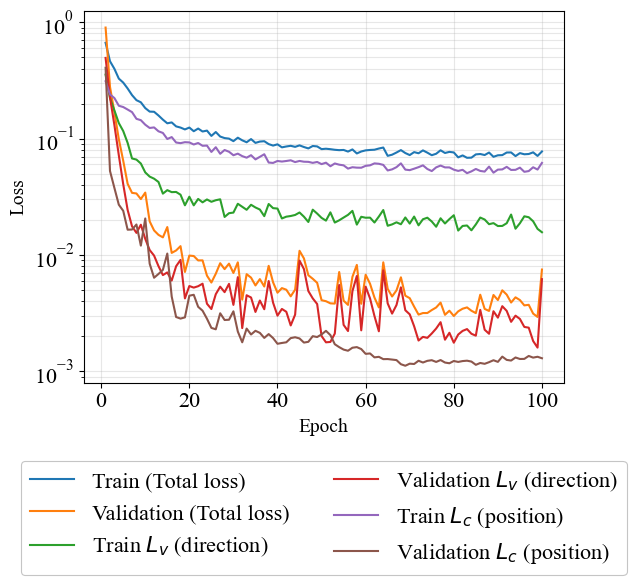

In [25]:
import numpy as np
import matplotlib.pyplot as plt

epochs = [r["epoch"] for r in history]

train_loss = [r.get("train_loss", np.nan) for r in history]
val_loss   = [r.get("val_loss",   np.nan) for r in history]

train_Lv = [r.get("train_Lv", np.nan) for r in history]
val_Lv   = [r.get("val_Lv",   np.nan) for r in history]

train_Lc = [r.get("train_Lc", np.nan) for r in history]
val_Lc   = [r.get("val_Lc",   np.nan) for r in history]

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(epochs, train_loss, label="Train (Total loss)")
ax.plot(epochs, val_loss,   label="Validation (Total loss)")

ax.plot(epochs, train_Lv, label="Train $L_v$ (direction)")
ax.plot(epochs, val_Lv,   label="Validation $L_v$ (direction)")

ax.plot(epochs, train_Lc, label="Train $L_c$ (position)")
ax.plot(epochs, val_Lc,   label="Validation $L_c$ (position)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
#ax.set_title("Training and validation loss convergence")
ax.set_yscale("log")
ax.grid(True, which="both", alpha=0.3)

# 👇 LEGEND UNDER PLOTTET MED SVAK GRÅ BOKS
leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=True,
    facecolor="white",
    edgecolor="0.75",
    framealpha=0.9
)
leg.get_frame().set_linewidth(0.8)

# 🎯 EKSPLOISITT KONTROLL AV MARGINS (IKKE tight_layout)
plt.subplots_adjust(
    left=0.15,    # fast venstre-margin → lik bredde som andre plott
    right=0.95,
    top=0.92,
    bottom=0.30   # plass til legend under
)

plt.savefig(FIG_DIR / "learning_curves_total_Lv_Lc_log.png", dpi=300, bbox_inches="tight")
plt.show()


## Direction and position accuracy curves

This cell plots the model accuracy over training epochs for both axis direction and axis position.

It generates two figures:

- **Axis direction error**  
  Shows the mean angular error (in degrees) between predicted and ground-truth axis direction.

- **Axis position error**  
  Shows the position accuracy as RMSE of the predicted axis point (in mm).

These plots help monitor how both orientation and position accuracy improve during training.

The figures are saved to the results folder:
- `learning_curve_angle_deg.png`
- `learning_curve_pos_rmse.png`

Location: `<INPUT_DIR>/ResultFiles<NUM_BEAMS>/`



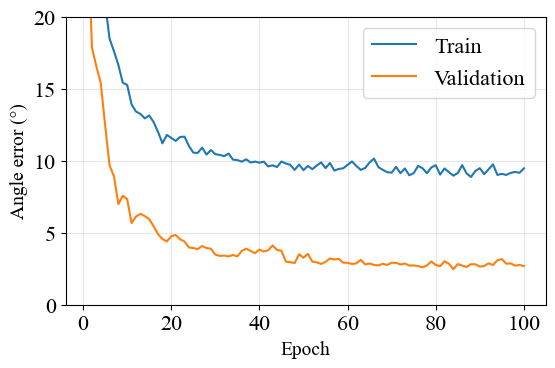

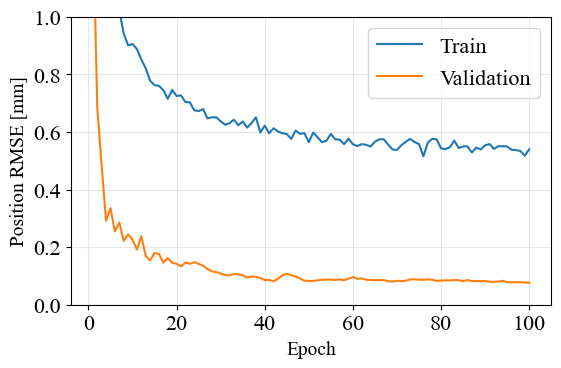

In [42]:
import numpy as np
import matplotlib.pyplot as plt

epochs = [r["epoch"] for r in history]

train_angle = [r.get("train_angle_deg", np.nan) for r in history]
val_angle   = [r.get("val_angle_deg",   np.nan) for r in history]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(epochs, train_angle, label="Train")
ax.plot(epochs, val_angle,   label="Validation")

ax.set_xlabel("Epoch")
ax.set_ylabel("Angle error (°)")
#ax.set_title("Axis direction accuracy")
ax.set_ylim(0, 20)
#ax.set_xlim(0, 70)
ax.grid(True, alpha=0.3)

ax.legend(loc="upper right")

# 🎯 Fast kontroll på margins → lik aksbredde som andre plott
plt.subplots_adjust(
    left=0.15,
    right=0.95,
    top=0.90,
    bottom=0.18
)

plt.savefig(FIG_DIR / "learning_curve_angle_deg.png", dpi=300)
plt.show()

train_pos_rmse = [r.get("train_pos_rmse", np.nan) for r in history]
val_pos_rmse   = [r.get("val_pos_rmse",   np.nan) for r in history]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(epochs, train_pos_rmse, label="Train")
ax.plot(epochs, val_pos_rmse,   label="Validation")

ax.set_xlabel("Epoch")
ax.set_ylabel("Position RMSE [mm]")
#ax.set_title("Axis position accuracy")
ax.set_ylim(0, 1)
#ax.set_xlim(0, 70)
ax.grid(True, alpha=0.3)

ax.legend(loc="upper right")

# 🎯 Samme margins → identisk bredde
plt.subplots_adjust(
    left=0.15,
    right=0.95,
    top=0.90,
    bottom=0.18
)

plt.savefig(FIG_DIR / "learning_curve_pos_rmse.png", dpi=300)
plt.show()




